## Exercise 
In this exercise you should aim to improve the recognition rate on the MNIST dataset using SVM. Use the provided training set to build your SVM. Apply the trained SVM to classify the test set. Investigate at least two different kernels and optimize the SVM parameters by means of cross-validation.

## Analysis of the theory
The main idea is that based on the labeled data (training data) the algorithm tries to find the optimal hyperplane which can be used to classify new data points. In two dimensions the hyperplane is a simple line. The hyperplane is a decision boundary which separates between given set of data points haven different class labels. 
The SVM classifier separates data points using a hyperplane with the maximum amount of margin. This hyperplane is known as the maximum margin hyperplane and the linear classifier it defines is known as the maximum margin classifier.


In [1]:
import pandas as pd
import time
import csv
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from pandas import read_csv

import csv
import numpy as np

train_data = read_csv('mnist_train.csv',header=None).to_numpy()
test_data = read_csv('mnist_test.csv', header=None).to_numpy()

X_train = train_data[:,1:]
y_train = train_data[:,0]
X_test = test_data[:3000,1:]
y_test = test_data[:3000,0]

X = X_train[:3000]
y = y_train[:3000]



## Build a SVM (linear kernel) 
To start, I would propose a linear kernel and some C values. Just to get a feeling, what values one can expect. 

In [7]:
c = [0.001, 0.01, 0.1, 1, 10]
for i in c:
    t100 = time.perf_counter()
    svc_linear = SVC(kernel="linear", C = i, cache_size = 4000) # SVC object
    svc_linear.fit(X, y) #fit
    pred = svc_linear.predict(X_test)
    print('Model accuracy score with linear kernel and C =', i, ': {0:0.4f}'.format(
        accuracy_score(y_test, pred)))  # default hyperparameters: C = 1.0, kernel= rbf, gamma = auto


Model accuracy score with linear kernel and C = 0.001 : 0.8617
Model accuracy score with linear kernel and C = 0.01 : 0.8617
Model accuracy score with linear kernel and C = 0.1 : 0.8617
Model accuracy score with linear kernel and C = 1 : 0.8617
Model accuracy score with linear kernel and C = 10 : 0.8617


### About the above Code
* The fit method of the SVC class is called to train the algorithm on the training data, which is passed as a parameter to the fit method.
* Regularisation parameter C tells the SVM optimisation how much you want to avoid miss classifying each training example. 
	* if parameter /C/ is higher, optimisation will choose smaller margin hyperplane, so training data miss classification rate will be lower
	* parameter /Gamma/: the gamma parameter defines how far the influence of a single training example reaches. High Gamma will only consider points close to the plausible hyperplane. Low Gamma will also consider points at greater distance. 
	* our Margin: higher margin results better model, so better classification (or prediction). Margin should always be maximized. 



One can also plot the accuary score as heatmaps. Underneath is one example for the case that C = 10000

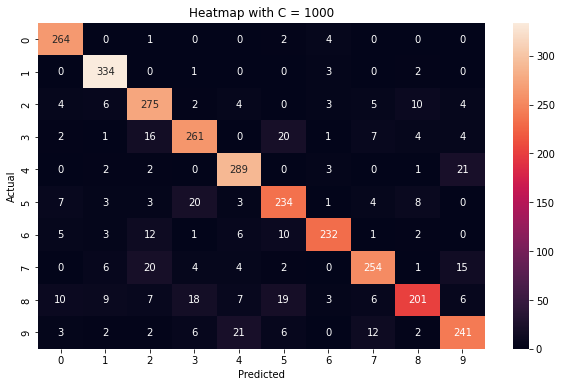

In [8]:
confusion_map = confusion_matrix(y_true=y_test, y_pred=pred)
plt.subplots(figsize=(10, 6))
sb.heatmap(confusion_map, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Heatmap with C = 1000")
plt.show()

If we have non linear data and there is no good way to separate our data with a linear hyperplane then we have to use other kernels. So let's look at the rbf kernel (Radial basis function kernel). Typically, this type of kernel takes the form of a function z that maps a single vector to a vector of higher dimensionality.


So instantiate a classifier with default hyperparameters: 

## Build a SVM (rbf kernel) 

In [11]:
c_rbf = [100.0, 1000.0, 1, 0.1]
gamma = [0.001, 0.01, 0.1, 1, 'scale', 'auto']
for i in c_rbf:
    for j in gamma: 
        t100 = time.perf_counter()
        svc = SVC(C=i, gamma = j, kernel="rbf", cache_size = 4000)
        svc.fit(X, y)
        y_pred = svc.predict(X_test)
        print('Model accuracy score with rbf kernel and C', i, 'and gamma', j, ': {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C 100.0 and gamma 0.001 : 0.1133
Model accuracy score with rbf kernel and C 100.0 and gamma 0.01 : 0.1133
Model accuracy score with rbf kernel and C 100.0 and gamma 0.1 : 0.1133
Model accuracy score with rbf kernel and C 100.0 and gamma 1 : 0.1133
Model accuracy score with rbf kernel and C 100.0 and gamma scale : 0.9270
Model accuracy score with rbf kernel and C 100.0 and gamma auto : 0.1133
Model accuracy score with rbf kernel and C 1000.0 and gamma 0.001 : 0.1133
Model accuracy score with rbf kernel and C 1000.0 and gamma 0.01 : 0.1133
Model accuracy score with rbf kernel and C 1000.0 and gamma 0.1 : 0.1133
Model accuracy score with rbf kernel and C 1000.0 and gamma 1 : 0.1133
Model accuracy score with rbf kernel and C 1000.0 and gamma scale : 0.9270
Model accuracy score with rbf kernel and C 1000.0 and gamma auto : 0.1133
Model accuracy score with rbf kernel and C 1 and gamma 0.001 : 0.1133
Model accuracy score with rbf kernel and C 1 and gam

One can see here from the data, that the C value, the higher it is, the better the accuarcy. Apparaently .94 is the best result. 

## Optimize the parameters
So we built roughly our model, but the accuracy is not too high yet. Therefore, we should optimize our parameters (C and Gamma). 
Now for optimizing our parameters in our data set, one could do a k-fold cross validation. To start off, one should define the number of folds one wants to have and and then use the cross_val_score method which valuates the accuracy score by cross-validation.

1. Create the folds. 
2. Use GridSearchCV to find the best estimator with the best parameters. 


### Create the folds
create partitions: KFold provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds. Each fold is then used once as a validation while the k - 1 remaining folds form the training set. 

In [16]:
partition = KFold(n_splits = 10, shuffle = True, random_state = 4)

### GridSearchCV - find best estimator  
So now let's move on and create the our svc model with multiple possibilites of params and get the best combination using GridSearchCV, which which should test different parameters and outputs the best ones which would give us our best score. Keep in mind that with high *C* values optimisation will choose smaller margin hyperplane, so training data miss classification rate will be lower (but we also have the danger of overfitting)
parameter *Gamma*: the gamma parameter defines how far the influence of a single training example reaches. High Gamma will only consider points close to the plausible hyperplane. Low Gamma will also consider points at greater distance.

So first, let's have a look at a linear kernel: So first, let's have a look at a linear kernel, whereas the parameters scale and class-weight mean the following: 
*scale:* 1 / (n_features * X.var()) as value of gamma, 
*balanced:* the “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

Below, we define the linear model and then with the help of GridSearchCV, find the best C with the highest accuracy. 

First, look at the linear model, then at the rbf model 

In [18]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10]
            }    

model = SVC(kernel="linear", class_weight='balanced', cache_size = 1000)
grid = GridSearchCV(estimator = model, param_grid = parameters,
                        cv=partition, n_jobs = -1, return_train_score =True
                          )


grid.fit(X, y)
grid.best_params_
scores = pd.DataFrame.from_dict(grid.cv_results_)


In [ ]:
scores['accuracy']

Accuracy : 0.8616666666666667


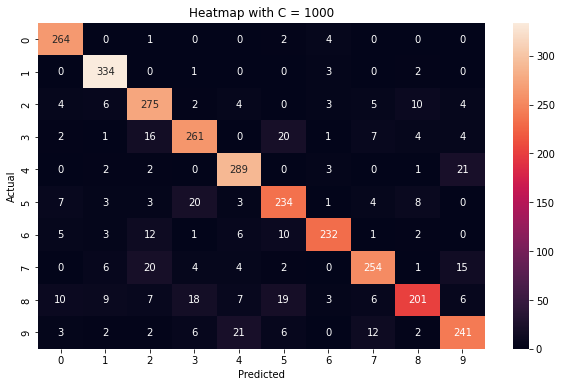

In [20]:
C = 0.001

grid = SVC(kernel = "linear", C=C, cache_size=4000)
grid.fit(X, y)
y_prediction = grid.predict(X_test)
print('Accuracy :',accuracy_score(y_test,y_prediction))
confusion_map = confusion_matrix(y_true=y_test, y_pred=y_prediction)
plt.subplots(figsize=(10, 6))
sb.heatmap(confusion_map, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Heatmap with C = 1000")
plt.show()

In [ ]:
parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1, 1, 'scale', 'auto']
            }    

model = SVC(kernel="rbf", class_weight='balanced', cache_size = 1000)
grid = GridSearchCV(estimator = model, param_grid = parameters,
                        cv=partition, n_jobs = -1
                          )


grid.fit(X, y)
grid.best_params_

scores = pd.DataFrame.from_dict(grid.cv_results_)
scores

Accuracy : 0.927


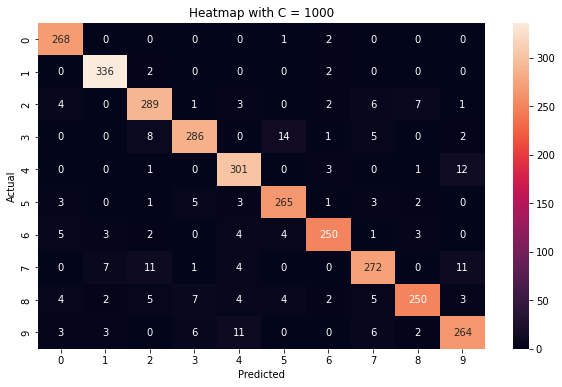

In [39]:
C = 10
gamma = 'scale'

grid = SVC(kernel="rbf", C=C, gamma=gamma, cache_size=4000)
grid.fit(X, y)
y_prediction = grid.predict(X_test)
print('Accuracy :',accuracy_score(y_test,y_prediction))
confusion_map = confusion_matrix(y_true=y_test, y_pred=y_prediction)
plt.subplots(figsize=(10, 6))
sb.heatmap(confusion_map, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Heatmap with C = 1000")
plt.show()